In [1]:
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
sys.path.append('../modules')
import geone as gn
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.transform import Affine

import fonctions_roussillon as fr

In [2]:
cmap = colors.ListedColormap(['orange', 'forestgreen','sienna','gold','navy','darksalmon','lightblue'])
bounds=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [3]:
geol_path="../data/cross_section/geol_complete.tif"

In [4]:
geol=fp.utils.Raster.load(geol_path)

In [5]:
cr=gpd.read_file('../data/cross_section/cr_demmer.shp')

demmerx=24100
demmerx_real=702705
transfo=demmerx_real-demmerx

alt_liss=cr.alt.rolling(100).mean()

In [6]:
x0,x1,z0,z1=24100,27500,-400,10

extent=[x0,x1,z0,z1]


Lz = z1-z0
resz=2
nlay = int(Lz/resz)
delz = np.ones(nlay)*resz

Lx = x1-x0
resx=20
ncol = int(Lx/resx)
delr= np.ones(ncol)*resx

xs=np.linspace(x0+resx/2,x1-resx/2,ncol)
top=np.interp(xs,cr.geometry.x.values-transfo,alt_liss)
top=pd.Series(top).fillna(method='bfill').values

vertices=[]
cell2d=[]
for i in range(nlay):
    for j in range(ncol):
        vertices.append([ncol*i+j,xs[j]-resx/2,top[j]-resz*i])
        cell2d.append([ncol*i+j,xs[j],top[j]-resz*(i+.5),ncol*i+j])

grid= fp.discretization.StructuredGrid(delz,delr,xoff=x0,yoff=z0)
grid2 = fp.discretization.VertexGrid(vertices=vertices,cell2d=cell2d)

print(nlay,ncol)

205 170


In [7]:
geogr=geol.resample_to_grid(grid,band = 1,method="nearest")

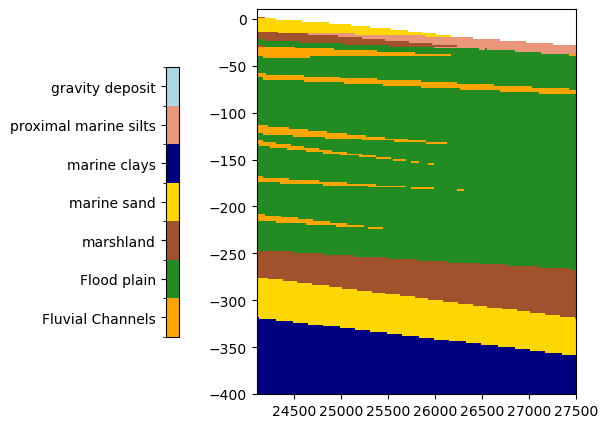

In [8]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
coupe=ax.imshow(geogr, cmap=cmap, norm=norm,interpolation='none',extent=[x0,x1,z0,z1],aspect='10')
cbar=plt.colorbar(coupe,location='left',ticks=[1,2,3,4,5,6,7],shrink=.7)
cbar.ax.set_yticklabels(['Fluvial Channels','Flood plain','marshland','marine sand','marine clays','proximal marine silts','gravity deposit']);
plt.savefig('../Figs/setup_SWI.png',dpi=300,bbox_inches='tight')

(24100.0, 27500.0)

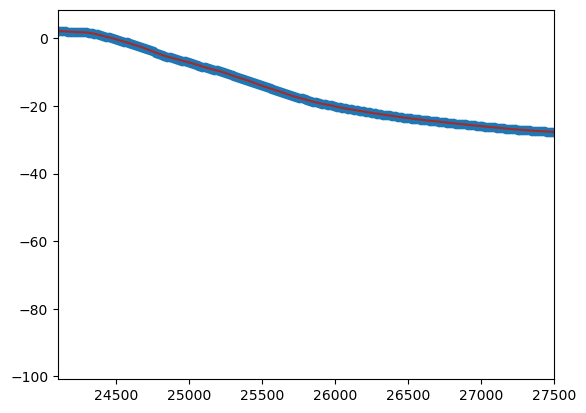

In [9]:
plt.plot(cr.geometry.x-transfo,alt_liss,color='brown')
plt.scatter(xs,top)
plt.xlim(x0,x1)

# Estimation K

In [10]:
acurve = -np.arctan(np.diff(alt_liss[::100])/np.diff(cr.geometry.x[::100]))*180.0/np.pi

In [11]:
posx=cr.geometry.x[::100][1:].values-transfo
x=np.linspace(x0,x1-delr[0],ncol)
angle_grid=np.interp(x,posx,acurve)
angle_grid=np.nan_to_num(angle_grid,0)

In [12]:
delr[0]/delz[0]

10.0

In [13]:
angle=np.zeros((np.shape(geogr)[0],np.shape(geogr)[1]))
for i in range(len(angle_grid)):
    angle[:,i]=angle_grid[i]*delr[0]/delz[0]



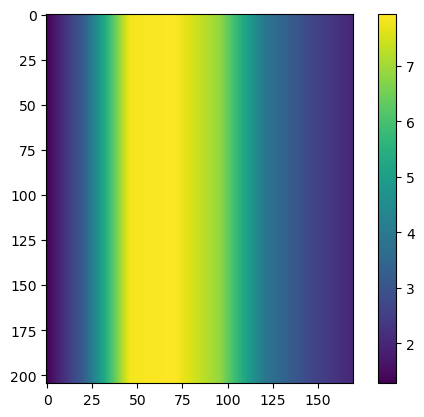

In [14]:
plt.imshow(angle)
plt.colorbar()

In [15]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel2D(elem=[
    ('spherical', {'w':1, 'r':[80.,15.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying angle: alpha in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.set_alpha(angle)

simulate2D: Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
simulate2D: Geos-Classic run complete


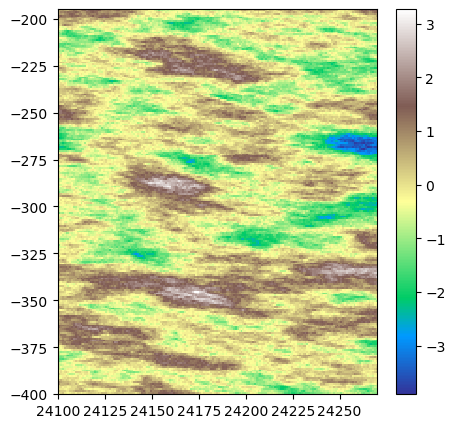

In [16]:
nreal = 1
np.random.seed()
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model_loc_ref, (ncol, nlay), (1,1), (x0, z0), 
                                                        method='simple_kriging', nneighborMax=20, nreal=nreal, 
                                                        nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

In [17]:
out=-1*geosclassic_output['image'].val

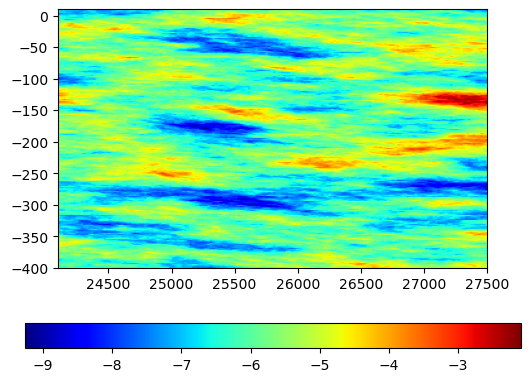

In [18]:
plt.imshow(np.flipud(out[0][0]-6),extent=[x0,x1,z0,z1],aspect='5',cmap='jet')
plt.colorbar(location='bottom')

In [19]:
K=np.copy(geogr)
K_mean=np.copy(geogr)
K_std=np.copy(geogr)
S=np.copy(geogr)

In [20]:
k_mean=[-5.5,-5.5,-8.5,-4.5,-10,-8,-6]
k_std=[1/1.2,1/1.2,1/2.5,1/6,1/10,1/3,1/2]
s_mean=np.log10(np.array([5e-3,1.5e-4,1e-6,2e-3,1e-6,1e-6,1e-4]))

In [21]:
for i in range(1,8):
    K[geogr==i]=np.flipud(out[0][0])[geogr==i]*k_std[i-1]+k_mean[i-1]
    K_mean[geogr==i]=k_mean[i-1]
    K_std[geogr==i]=k_std[i-1]
    S[geogr==i]=s_mean[i-1]

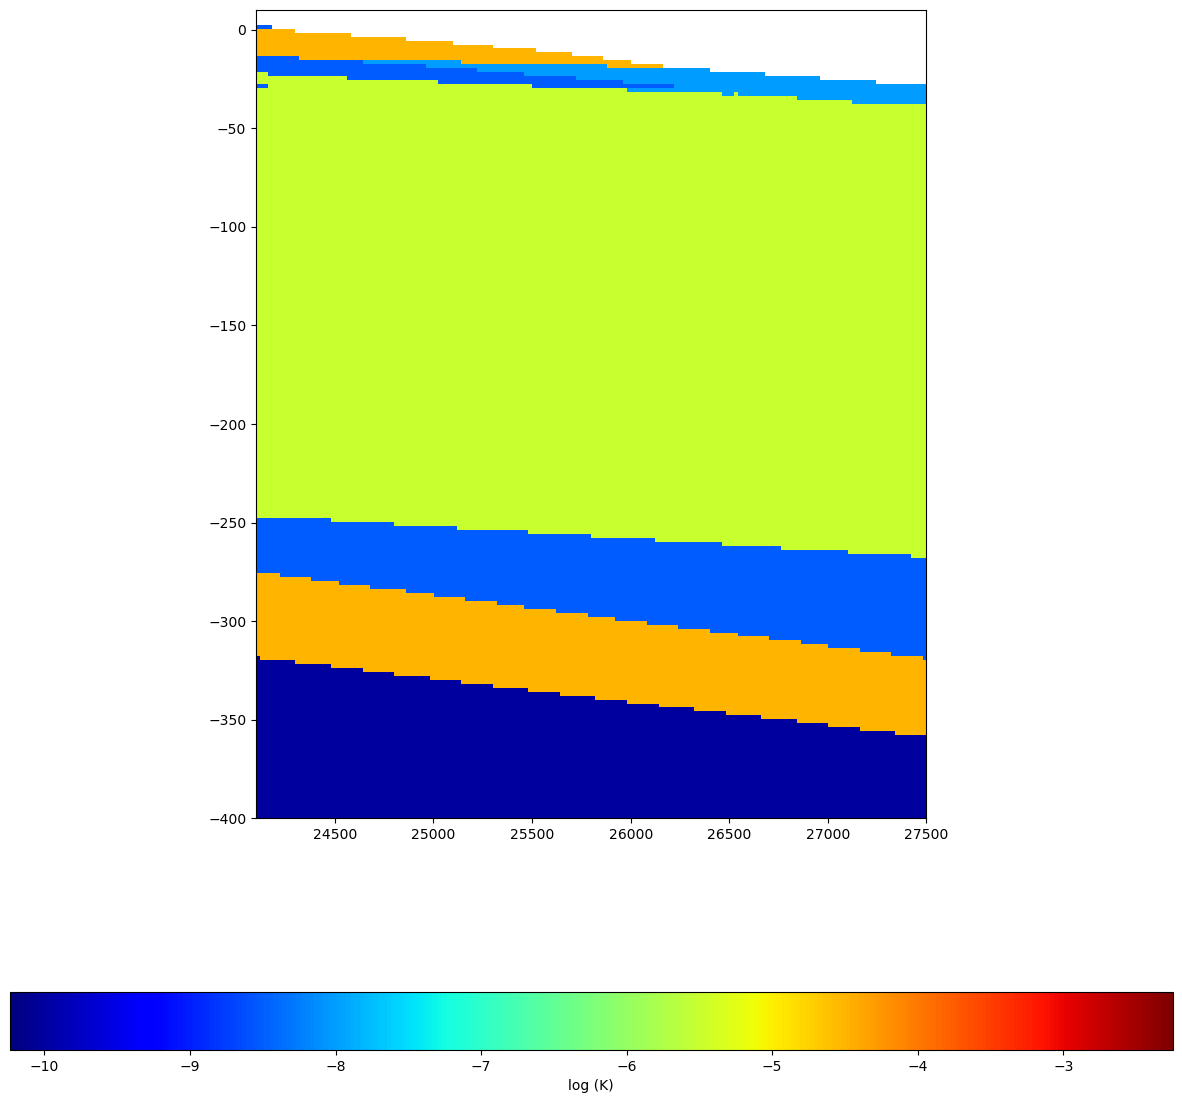

In [22]:
plt.figure(figsize=(15,15))
plt.imshow(K_mean,extent=[x0,x1,z0,z1],aspect='10',cmap='jet',vmin=np.nanmin(K),vmax=np.nanmax(K))
plt.colorbar(location='bottom',label='log (K)')
plt.savefig('../Figs/K_mean.png',dpi=720,bbox_inches='tight')

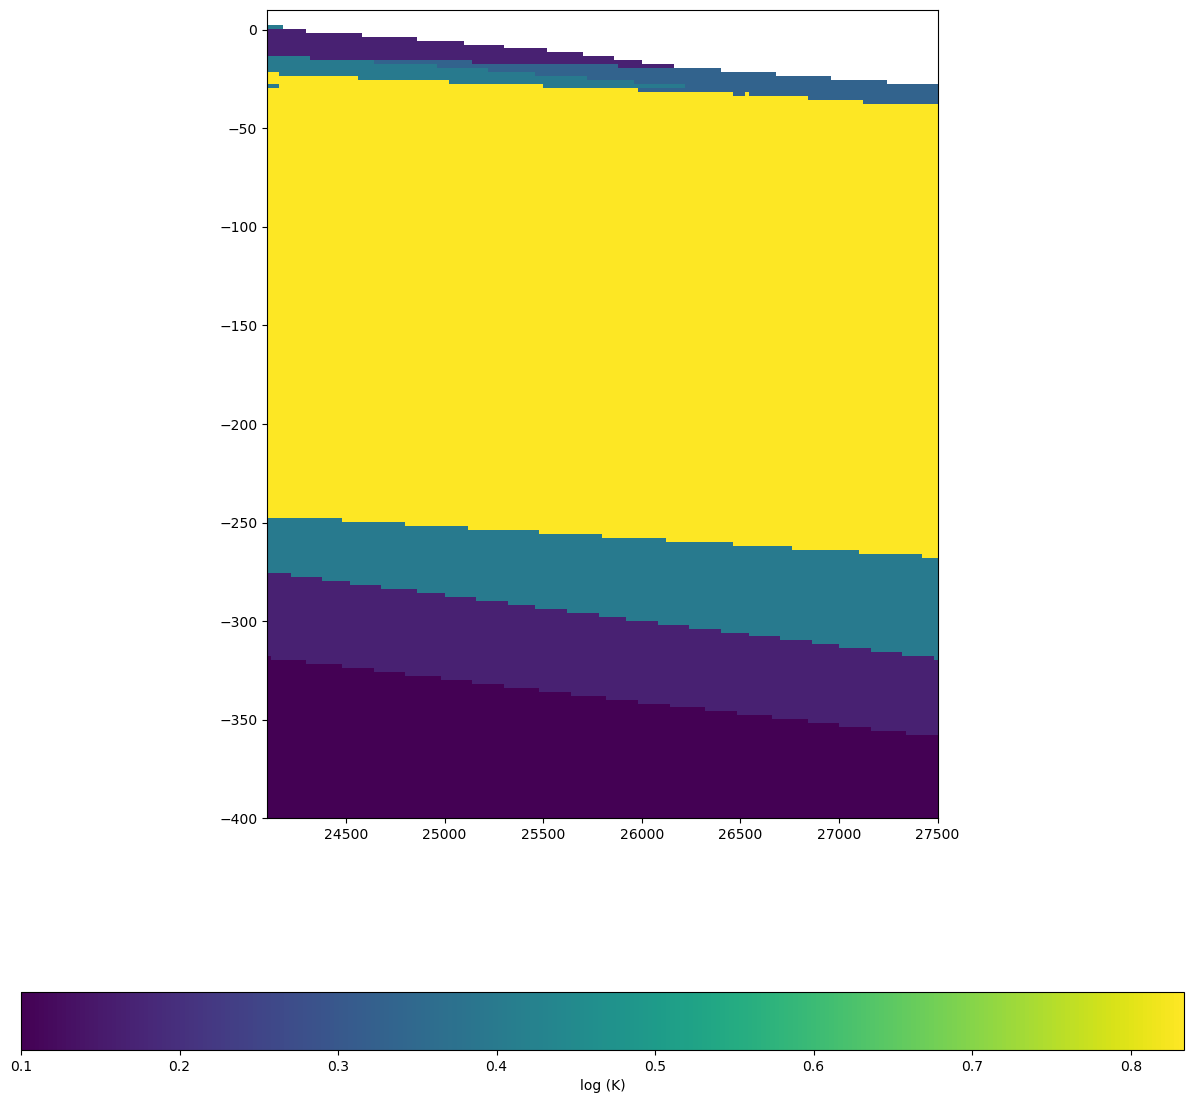

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(K_std,extent=[x0,x1,z0,z1],aspect='10',cmap='viridis')
plt.colorbar(location='bottom',label='log (K)')
plt.savefig('../Figs/K_std.png',dpi=720,bbox_inches='tight')

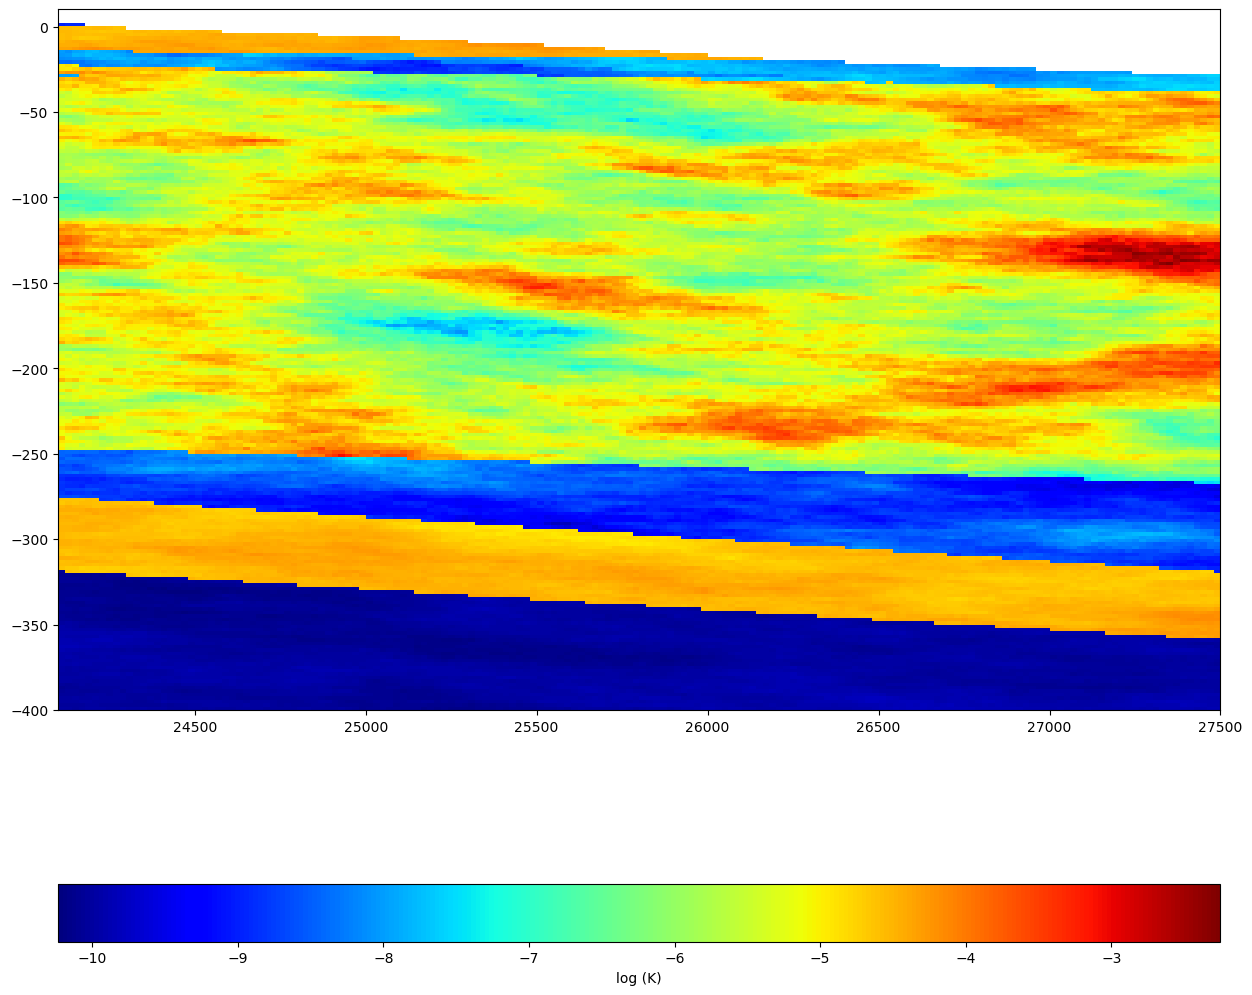

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(K,extent=[x0,x1,z0,z1],aspect='5',cmap='jet',vmin=np.nanmin(K),vmax=np.nanmax(K))
plt.colorbar(location='bottom',label='log (K)')
plt.savefig('../Figs/K_map.png',dpi=720,bbox_inches='tight')

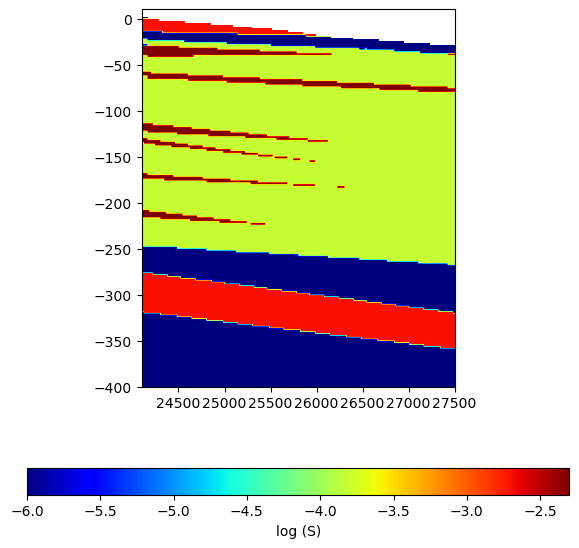

In [25]:
%matplotlib inline
plt.figure(figsize=(7,7))
plt.imshow(S,extent=[x0,x1,z0,z1],aspect='10',cmap='jet')
plt.colorbar(location='bottom',label='log (S)')
plt.savefig('../Figs/S_mean.png',dpi=720,bbox_inches='tight')

In [26]:
#save as tif

transform = Affine.translation(x0, z0) * Affine.scale(resx, resz)

with rasterio.open(
        "../data/K1.tif",
        mode="w",
        driver="GTiff",
        height=K.shape[0],
        width=K.shape[1],
        count=2,
        dtype=K.dtype,
        transform=transform,
) as new_dataset:
        new_dataset.write(np.flipud(K), 1)
        new_dataset.write(np.flipud(S), 2)

In [27]:
#Interpolate to unstructured grid

K1=fp.utils.Raster.load('../data/K1.tif')
K2=K1.resample_to_grid(grid2,band = 1,method="nearest")
K2=pd.Series(K2).interpolate().values
K_res=np.reshape(K2,(nlay,ncol))

S1=fp.utils.Raster.load('../data/K1.tif')
S2=S1.resample_to_grid(grid2,band = 2,method="nearest")
S2=pd.Series(S2).interpolate().values
S_res=np.reshape(S2,(nlay,ncol))

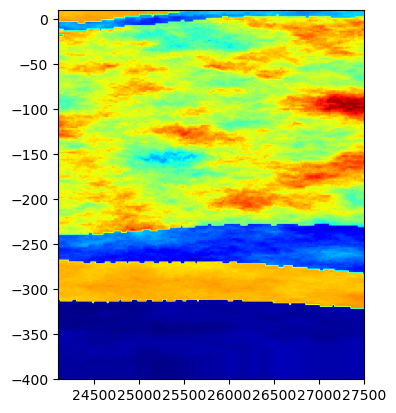

In [28]:
plt.imshow(K_res,extent=[x0,x1,z0,z1],aspect='10',cmap='jet')

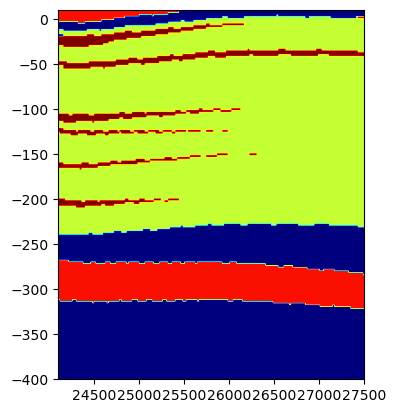

In [29]:
plt.imshow(S_res,extent=[x0,x1,z0,z1],aspect='10',cmap='jet')

(-400.0, 10.0)

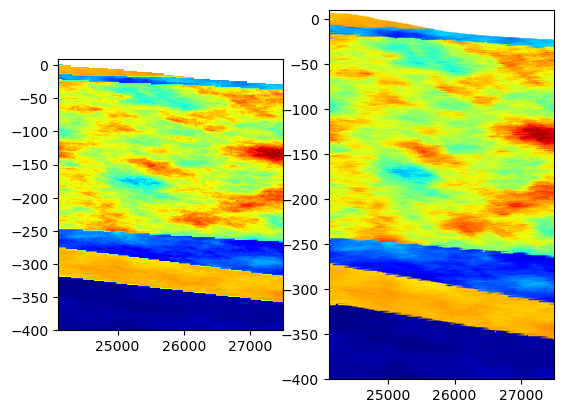

In [30]:
plt.subplot(121)
plt.imshow(K,extent=[x0,x1,z0,z1],aspect='10',cmap='jet')
plt.subplot(122)
plt.scatter(grid2.xcellcenters,grid2.ycellcenters,c=K2,cmap='jet',marker="s")
plt.xlim(x0,x1)
plt.ylim(z0,z1)

# Saves

In [31]:
fr.write_pickle("../data/cross_section/flopy",[delr,delz,K_res,S_res,top,grid,extent])

In [32]:
np.savetxt('../data/Kposter.txt',K_res)